In [23]:
# take 10% of images from each class to validation

In [24]:
# there are B&W images in data!

In [25]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus // 2

DEVICE = 'cuda:4' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:4'

### Data

In [26]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None,
                 augment_transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [27]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [28]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [29]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [30]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data
from xml.dom.expatbuilder import theDOMImplementation


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=128, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

mean = mean.cpu()
std = std.cpu()

print(f'Mean: {mean}')
print(f'Std: {std}')

train_img_transform = T.Compose([
    T.ToTensor(),
    # T.RandomRotation([-30, 30]),
    T.RandomHorizontalFlip(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=1.0)  # Always flip the image
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [31]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform,
                                    augment_transform=augment_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [32]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [33]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [34]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_number_of_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [35]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  
                  padding=kernel_size // 2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_shape, out_shape))
        
        if activation is not None:
            layers.append(activation)

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(out_shape))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [36]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [37]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 64, kernel_size=5, n_conv_layers=1)
        self.conv2 = CnnBlock(64, 128, kernel_size=5, n_conv_layers=1)
        self.conv3 = CnnBlock(128, 256, kernel_size=5, n_conv_layers=1)
        self.conv4 = CnnBlock(256, 512, kernel_size=5, n_conv_layers=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.fc1 = FcBlock(512 * 4 * 4, 1024, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(1024, 200, do_batchnorm=True, activation=nn.ReLU())

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

---

### Train

In [38]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [39]:
set_seed(123)

model = BaselineModel()
print(get_number_of_trainable_params(model))

for layer in model.named_parameters():
    print(layer[0], layer[1].numel())

model.to(DEVICE)

Random seed set as 123
12905560
conv1.conv_layers.0.weight 4800
conv1.conv_layers.0.bias 64
conv1.conv_layers.1.weight 64
conv1.conv_layers.1.bias 64
conv2.conv_layers.0.weight 204800
conv2.conv_layers.0.bias 128
conv2.conv_layers.1.weight 128
conv2.conv_layers.1.bias 128
conv3.conv_layers.0.weight 819200
conv3.conv_layers.0.bias 256
conv3.conv_layers.1.weight 256
conv3.conv_layers.1.bias 256
conv4.conv_layers.0.weight 3276800
conv4.conv_layers.0.bias 512
conv4.conv_layers.1.weight 512
conv4.conv_layers.1.bias 512
fc1.layers.0.weight 8388608
fc1.layers.0.bias 1024
fc1.layers.2.weight 1024
fc1.layers.2.bias 1024
fc2.layers.0.weight 204800
fc2.layers.0.bias 200
fc2.layers.2.weight 200
fc2.layers.2.bias 200


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [40]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 512,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'],)
# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [41]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [42]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [43]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------
[04:07:14] Step 20/176: train loss = 5.47734
[04:07:20] Step 40/176: train loss = 5.31806
[04:07:25] Step 60/176: train loss = 5.17705
[04:07:30] Step 80/176: train loss = 5.06184
[04:07:35] Step 100/176: train loss = 4.96
[04:07:40] Step 120/176: train loss = 4.86178
[04:07:45] Step 140/176: train loss = 4.76763
[04:07:50] Step 160/176: train loss = 4.6827
VALIDATION LOSS = 4.11231, VALIDATION ACCURACY = 0.1312


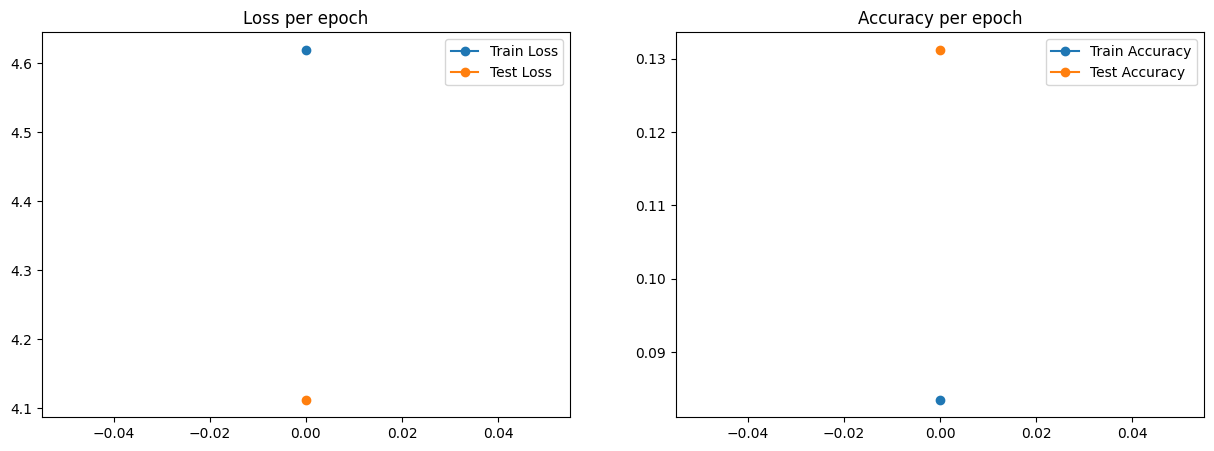

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[04:08:03] Step 20/176: train loss = 3.86451
[04:08:08] Step 40/176: train loss = 3.8315
[04:08:13] Step 60/176: train loss = 3.80571
[04:08:19] Step 80/176: train loss = 3.77108
[04:08:24] Step 100/176: train loss = 3.74056
[04:08:30] Step 120/176: train loss = 3.71685
[04:08:35] Step 140/176: train loss = 3.69739
[04:08:40] Step 160/176: train loss = 3.67495
VALIDATION LOSS = 3.58694, VALIDATION ACCURACY = 0.2161


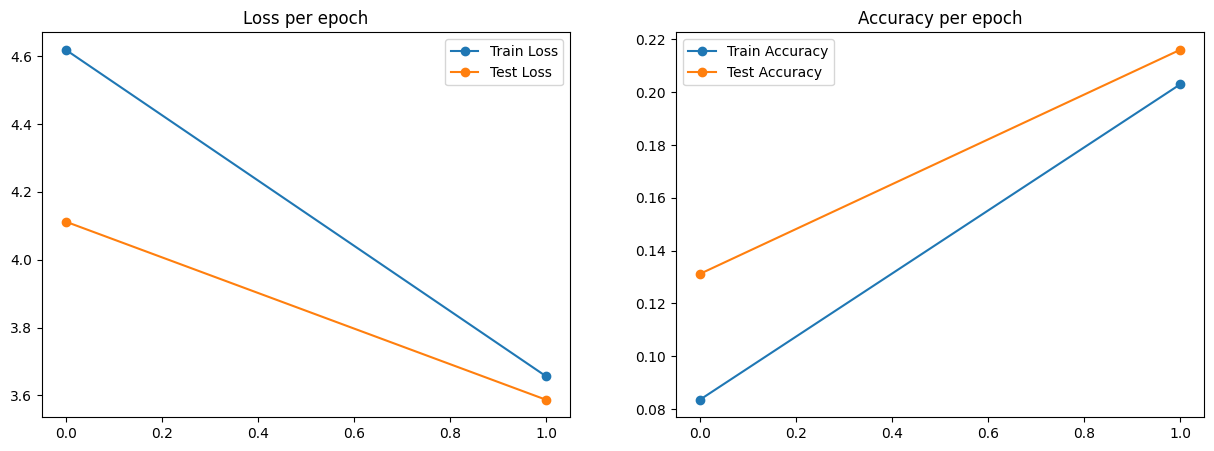

Saving best model

 		 ------------------------------ EPOCH: 3 ------------------------------
[04:08:54] Step 20/176: train loss = 3.32361
[04:08:59] Step 40/176: train loss = 3.32234
[04:09:04] Step 60/176: train loss = 3.31263
[04:09:10] Step 80/176: train loss = 3.30521
[04:09:16] Step 100/176: train loss = 3.29356
[04:09:21] Step 120/176: train loss = 3.28183
[04:09:27] Step 140/176: train loss = 3.26673
[04:09:32] Step 160/176: train loss = 3.25499
VALIDATION LOSS = 3.3157, VALIDATION ACCURACY = 0.2594


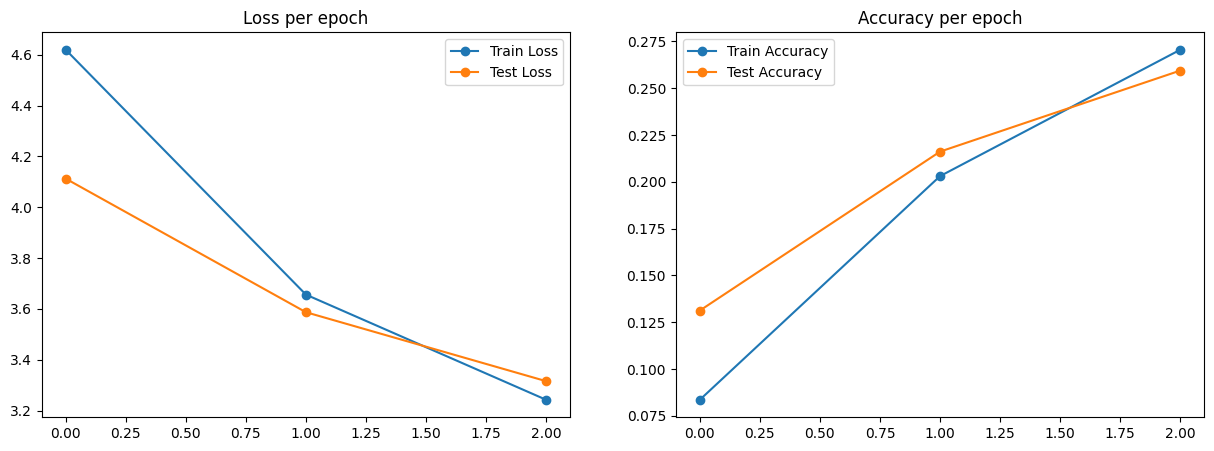

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[04:09:46] Step 20/176: train loss = 2.97696
[04:09:51] Step 40/176: train loss = 2.97989
[04:09:56] Step 60/176: train loss = 2.98057
[04:10:02] Step 80/176: train loss = 2.97727
[04:10:07] Step 100/176: train loss = 2.96767
[04:10:12] Step 120/176: train loss = 2.96047
[04:10:18] Step 140/176: train loss = 2.95082
[04:10:23] Step 160/176: train loss = 2.95751
VALIDATION LOSS = 3.13961, VALIDATION ACCURACY = 0.2933


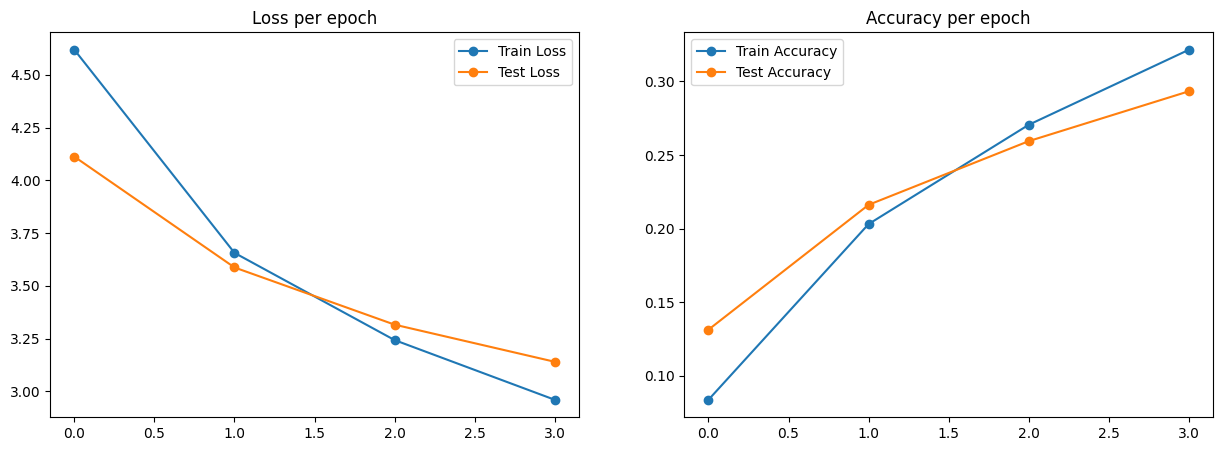

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[04:10:37] Step 20/176: train loss = 2.7318
[04:10:42] Step 40/176: train loss = 2.72959
[04:10:48] Step 60/176: train loss = 2.72645
[04:10:53] Step 80/176: train loss = 2.72666
[04:10:58] Step 100/176: train loss = 2.72263
[04:11:04] Step 120/176: train loss = 2.7176
[04:11:09] Step 140/176: train loss = 2.71537
[04:11:14] Step 160/176: train loss = 2.70354
VALIDATION LOSS = 2.86485, VALIDATION ACCURACY = 0.3455


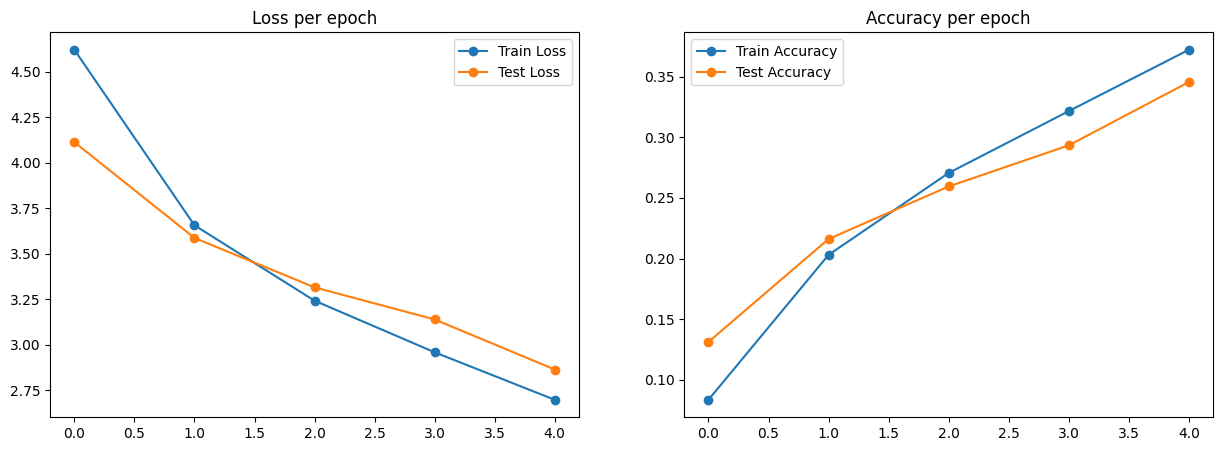

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[04:11:27] Step 20/176: train loss = 2.38041
[04:11:33] Step 40/176: train loss = 2.39675
[04:11:38] Step 60/176: train loss = 2.40877
[04:11:43] Step 80/176: train loss = 2.43099
[04:11:48] Step 100/176: train loss = 2.43638
[04:11:53] Step 120/176: train loss = 2.44446
[04:11:58] Step 140/176: train loss = 2.44796
[04:12:03] Step 160/176: train loss = 2.45154
VALIDATION LOSS = 2.83883, VALIDATION ACCURACY = 0.3508


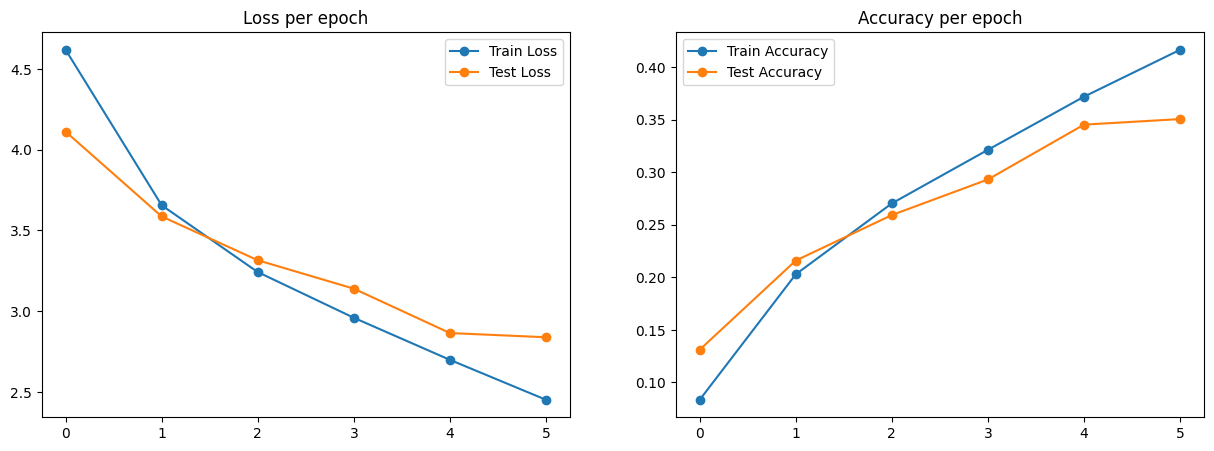

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[04:12:16] Step 20/176: train loss = 2.16393
[04:12:21] Step 40/176: train loss = 2.15973
[04:12:26] Step 60/176: train loss = 2.1761
[04:12:32] Step 80/176: train loss = 2.19343
[04:12:37] Step 100/176: train loss = 2.20954
[04:12:42] Step 120/176: train loss = 2.21538
[04:12:47] Step 140/176: train loss = 2.21717
[04:12:52] Step 160/176: train loss = 2.22363
VALIDATION LOSS = 2.68795, VALIDATION ACCURACY = 0.3805


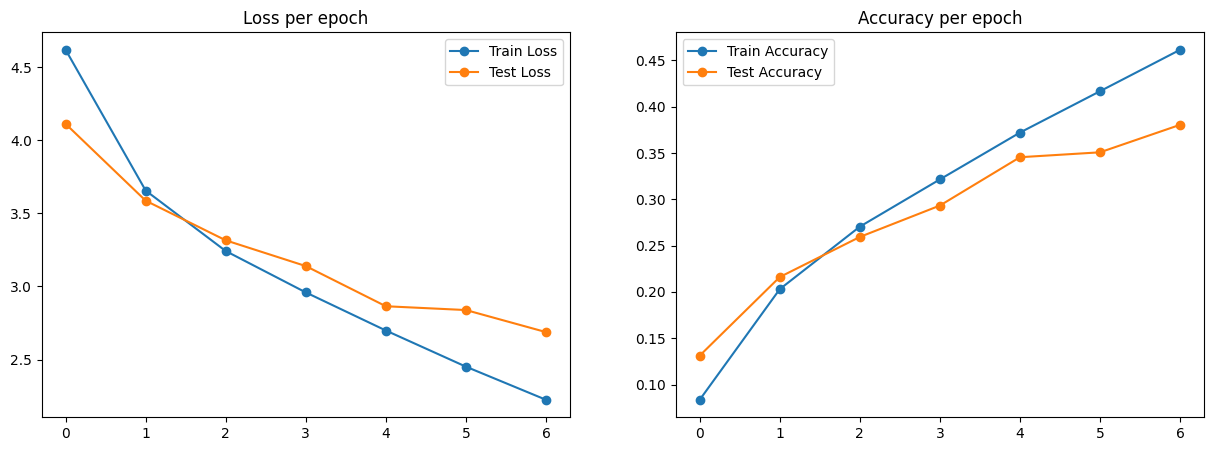

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[04:13:05] Step 20/176: train loss = 1.89144
[04:13:10] Step 40/176: train loss = 1.9227
[04:13:15] Step 60/176: train loss = 1.94061
[04:13:20] Step 80/176: train loss = 1.96515
[04:13:25] Step 100/176: train loss = 1.97448
[04:13:30] Step 120/176: train loss = 1.98714
[04:13:36] Step 140/176: train loss = 1.99907
[04:13:41] Step 160/176: train loss = 2.00967
VALIDATION LOSS = 2.62535, VALIDATION ACCURACY = 0.4018


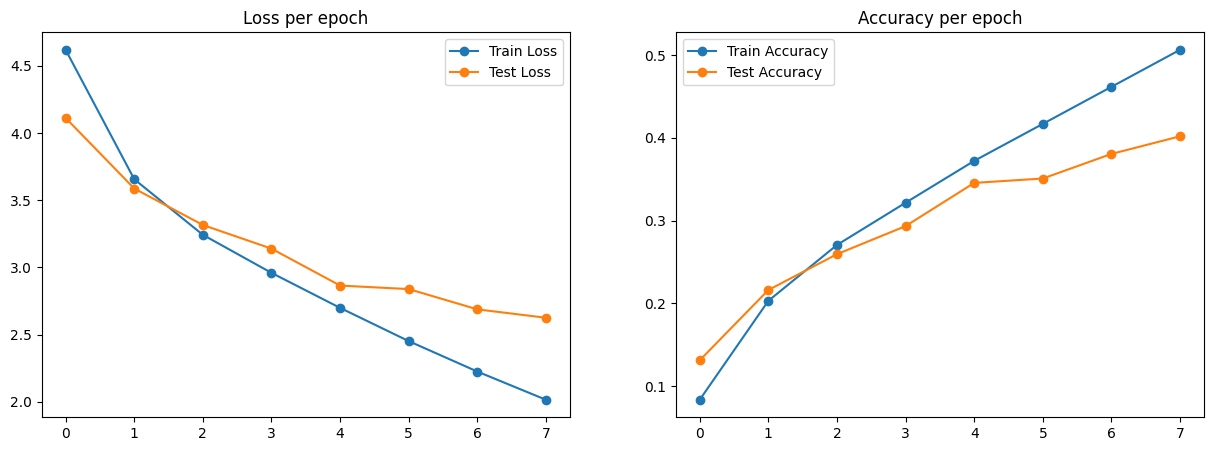

Saving best model

 		 ------------------------------ EPOCH: 9 ------------------------------
[04:13:54] Step 20/176: train loss = 1.66219
[04:13:59] Step 40/176: train loss = 1.66716
[04:14:04] Step 60/176: train loss = 1.68549
[04:14:09] Step 80/176: train loss = 1.7195
[04:14:14] Step 100/176: train loss = 1.74634
[04:14:19] Step 120/176: train loss = 1.7654
[04:14:24] Step 140/176: train loss = 1.77948
[04:14:29] Step 160/176: train loss = 1.79009
VALIDATION LOSS = 2.70297, VALIDATION ACCURACY = 0.389


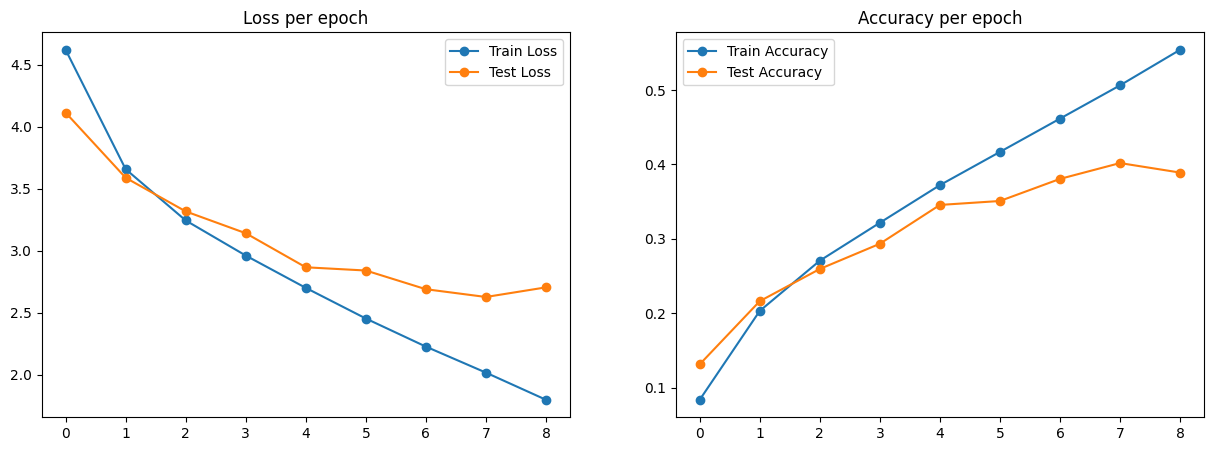

Validation loss didn't improve

 		 ------------------------------ EPOCH: 10 ------------------------------
[04:14:42] Step 20/176: train loss = 1.42739
[04:14:47] Step 40/176: train loss = 1.44731
[04:14:52] Step 60/176: train loss = 1.46978
[04:14:57] Step 80/176: train loss = 1.49104
[04:15:02] Step 100/176: train loss = 1.50866
[04:15:08] Step 120/176: train loss = 1.52803
[04:15:13] Step 140/176: train loss = 1.54485
[04:15:18] Step 160/176: train loss = 1.5614
VALIDATION LOSS = 2.75843, VALIDATION ACCURACY = 0.396


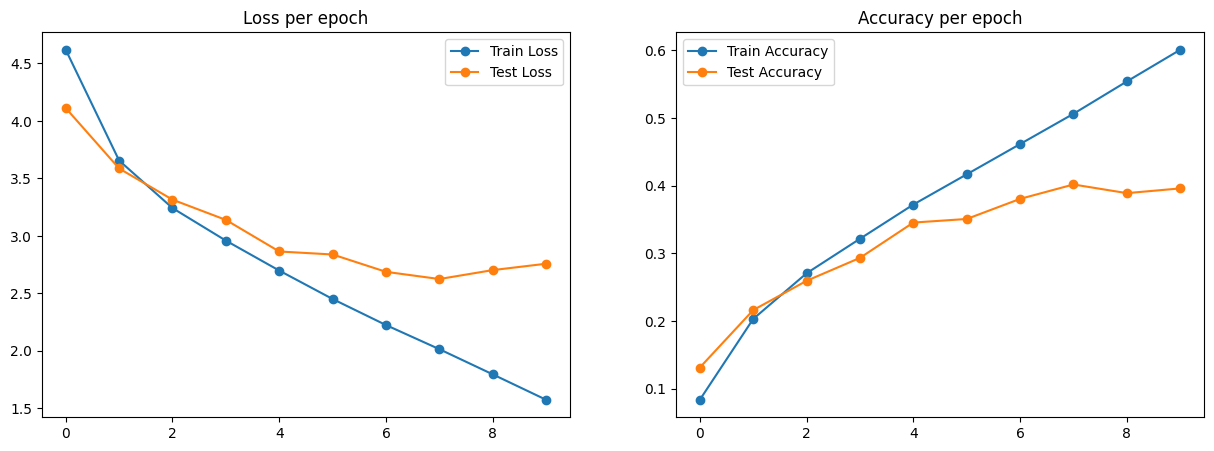

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.62535, last 2 epochs min: 2.70297
Restoring the model at epoch 7: test_accuracy = 0.4018
Model successfully restored

 Training time: 8.0 minutes 16.12 seconds

 Final model is stored to model_epoch_7_test_acc_0.4018.pth


In [44]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    # scheduler.step()
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
    if epoch == 10:
        for g in optimizer.param_groups:
            g['lr'] = 0.001
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [45]:
import pandas as pd

In [46]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [47]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [48]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [49]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[04:15:26] Step 10/79 done
[04:15:27] Step 20/79 done
[04:15:27] Step 30/79 done
[04:15:27] Step 40/79 done
[04:15:28] Step 50/79 done
[04:15:28] Step 60/79 done
[04:15:29] Step 70/79 done


In [50]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,174
2,2,116
3,3,29
4,4,67


In [51]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [52]:
test_predictions_df['class'].value_counts()

class
133    176
105    140
123    136
116    127
23     126
      ... 
106     13
199     13
88      11
33      11
176     10
Name: count, Length: 200, dtype: int64

In [53]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [54]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n09428293
2,val_2.JPEG,n07871810
3,val_3.JPEG,n04074963
4,val_4.JPEG,n03930313


In [55]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)